<a href="https://colab.research.google.com/github/antoniocfetngnu/InteligArtificial1/blob/main/1erParcial/1er_Parcial_Calderon_Enrique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primer Parcial Inteligencia Artificial I
## Nombre: Calderon Flores Enrique Antonio
## Carrera: Ing. En Ciencias de la Computación


# 1er Dataset: 10. Android Malware (Detection)

El dataset utilizado para la detección de malware en Android contiene información sobre diferentes aplicaciones para dispositivos Android. Cada instancia en el dataset representa una aplicación y está etiquetada como maliciosa o no maliciosa. Las características del dataset incluyen detalles como los permisos solicitados por la aplicación, las llamadas a la API realizadas, la actividad de red asociada con la aplicación, entre otros. Estos datos son utilizados para entrenar modelos de aprendizaje automático que pueden predecir si una nueva aplicación es maliciosa o no, basándose en patrones identificados en el comportamiento de las aplicaciones etiquetadas previamente.

## Elección de modelo: Clasificación multiclase OneVsAll
Analizando el dataset se puede concluir claramente que se quiere realizar una clasificación múltiple entre distintos tiposs de malware o si la aplicación es benigna. Ya que se tiene 4 categorías discretas, se debe emplear una clasifiación.

###Importacion de librerías

Primero importamos todas las librerías que necesitamos

In [140]:
import pandas as pd
import numpy as np
from scipy import optimize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

Ahora importamos el dataset como dataframe de pandas

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/1erParcial/Android_Malware.csv')

<ipython-input-142-53fa28e28e49>:1: DtypeWarning: Columns (56,58,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/1erParcial/Android_Malware.csv')


In [143]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/1erParcial/Android_Malware.csv',index_col=0, low_memory=False)
pd.set_option('display.max_columns', None)
print(df.describe())

        Source Port   Destination Port       Protocol   Flow Duration  \
count  3.556300e+05       3.556300e+05  355630.000000    3.556300e+05   
mean   3.914129e+04       5.202541e+03       9.765190    1.092975e+07   
std    1.794632e+04       1.452135e+04     750.541237    2.180861e+07   
min    0.000000e+00       0.000000e+00       0.000000   -1.000000e+00   
25%    3.455900e+04       8.000000e+01       6.000000    4.888600e+04   
50%    4.322600e+04       4.430000e+02       6.000000    5.602255e+05   
75%    5.228300e+04       4.430000e+02       6.000000    1.076907e+07   
max    1.045267e+06       1.328159e+06  442719.666667    1.199999e+08   

        Total Fwd Packets   Total Backward Packets  \
count       355630.000000             3.556300e+05   
mean             7.433718             1.420368e+01   
std             81.015658             2.220247e+03   
min              0.000000             0.000000e+00   
25%              1.000000             0.000000e+00   
50%              2

Reemplazo de espacios en blanco por guiones bajos en nombre de columnas para evitar errores.

In [144]:
df.columns = df.columns.str.replace(' ', '_')

## Preprocesado y Optimización
Se incluyó low_memory= False como parámetro en la importación del Dataset ya que nos indicaba que hay columnas que tienen más de un tipo de dato.

Columas con problemas (multiples datos) ['Flow_ID', '_CWE_Flag_Count', '_Down/Up_Ratio', 'Fwd_Avg_Bytes/Bulk']

In [145]:
# Obtiene información sobre los tipos de datos de cada columna
column_types = df.dtypes

# Inicializa una lista para almacenar las columnas con tipos de datos mixtos
mixed_type_columns = []

# Itera sobre las columnas y verifica si cada una tiene más de un tipo de dato
for column in column_types.index:
    unique_types = df[column].apply(type).unique()
    if len(unique_types) > 1:
        mixed_type_columns.append(column)

# Imprime las columnas con tipos de datos mixtos
print("Columnas con tipos de datos mixtos:")
print(mixed_type_columns)

Columnas con tipos de datos mixtos:
['Flow_ID', '_CWE_Flag_Count', '_Down/Up_Ratio', 'Fwd_Avg_Bytes/Bulk']


###Eliminación de valores nulos NAN de dataset

In [146]:
df = df.dropna()

###Eliminación de columnas de ID o relacionadas
Debido a que sus valores son únicos y no indican una escala de valores que tenga una relación ordinal o incremental

In [147]:
df = df.drop('Flow_ID', axis=1)
df = df.drop('_Source_IP', axis=1)
df = df.drop('_Destination_IP', axis=1)

### Preprocesamiento de Columna con valores de fecha y hora (TimeStamp)
Se extrae valores considerados útiles para el modelo. Se excluyó año ya que toda la información cuenta con el mismo valor para año.

In [148]:
df['_Timestamp'] = pd.to_datetime(df['_Timestamp'], dayfirst=True)
df['Month'] = df['_Timestamp'].dt.month
df['Day'] = df['_Timestamp'].dt.day
df['Hour'] = df['_Timestamp'].dt.hour
df['Minute'] = df['_Timestamp'].dt.minute
df = df.drop('_Timestamp', axis=1)

###Comprobación de múltiples tipos de datos en columnas señaladas (advertencia previa)

In [149]:
frecuencia1 = df['_CWE_Flag_Count'].value_counts()
print("Frecuencia de valores en la columna '_CWE_Flag_Count':")
print(frecuencia1)
print("----------------------")
frecuencia2 = df['_Down/Up_Ratio'].value_counts()
print("Frecuencia de valores en la columna '_Down/Up_Ratio':")
print(frecuencia2)
print("----------------------")
frecuencia3 = df['Fwd_Avg_Bytes/Bulk'].value_counts()
print("Frecuencia de valores en la columna 'Fwd_Avg_Bytes/Bulk':")
print(frecuencia3)
print("----------------------")

Frecuencia de valores en la columna '_CWE_Flag_Count':
_CWE_Flag_Count
0      352461
0.0      3165
Name: count, dtype: int64
----------------------
Frecuencia de valores en la columna '_Down/Up_Ratio':
_Down/Up_Ratio
0.0     154385
1.0     151914
0        20399
1        16749
2.0       7858
3.0       1993
2         1121
4.0        436
3          377
5.0        123
4           79
6.0         42
8.0         36
7.0         31
5           23
12.0        12
6           12
8            8
10.0         7
9.0          7
11.0         5
7            4
11           2
9            1
12           1
75.0         1
Name: count, dtype: int64
----------------------
Frecuencia de valores en la columna 'Fwd_Avg_Bytes/Bulk':
Fwd_Avg_Bytes/Bulk
0      288232
0.0     67394
Name: count, dtype: int64
----------------------


###Conversión a un mismo tipo de dato y comprobación de resultado.

In [150]:
df['_Down/Up_Ratio'] = df['_Down/Up_Ratio'].astype(float)
df['Fwd_Avg_Bytes/Bulk'] = df['Fwd_Avg_Bytes/Bulk'].astype(float)
df['_CWE_Flag_Count'] = df['_CWE_Flag_Count'].astype(float)

frecuencia1 = df['_CWE_Flag_Count'].value_counts()
print("Frecuencia de valores en la columna '_CWE_Flag_Count':")
print(frecuencia1)
print("----------------------")
frecuencia2 = df['_Down/Up_Ratio'].value_counts()
print("Frecuencia de valores en la columna '_Down/Up_Ratio':")
print(frecuencia2)
print("----------------------")
frecuencia3 = df['Fwd_Avg_Bytes/Bulk'].value_counts()
print("Frecuencia de valores en la columna 'Fwd_Avg_Bytes/Bulk':")
print(frecuencia3)
print("----------------------")

Frecuencia de valores en la columna '_CWE_Flag_Count':
_CWE_Flag_Count
0.0    355626
Name: count, dtype: int64
----------------------
Frecuencia de valores en la columna '_Down/Up_Ratio':
_Down/Up_Ratio
0.0     174784
1.0     168663
2.0       8979
3.0       2370
4.0        515
5.0        146
6.0         54
8.0         44
7.0         35
12.0        13
9.0          8
10.0         7
11.0         7
75.0         1
Name: count, dtype: int64
----------------------
Frecuencia de valores en la columna 'Fwd_Avg_Bytes/Bulk':
Fwd_Avg_Bytes/Bulk
0.0    355626
Name: count, dtype: int64
----------------------


###Eliminación de columnas que poseen el mismo valor para todas las tuplas (Desviación estandar=0)
Al tener el mismo valor no ofrecen nada al modelo, por tanto tendríamos características extras que se procesarían sin ningun beneficio.

In [151]:
columnas_a_eliminar = ['_Bwd_PSH_Flags', '_Fwd_URG_Flags', '_Bwd_URG_Flags',
                       'Fwd_Avg_Bytes/Bulk', '_CWE_Flag_Count', '_RST_Flag_Count', '_ECE_Flag_Count',
                       '_Fwd_Avg_Packets/Bulk', '_Fwd_Avg_Bulk_Rate', '_Bwd_Avg_Bytes/Bulk',
                       '_Bwd_Avg_Packets/Bulk', 'Bwd_Avg_Bulk_Rate']
df = df.drop(columnas_a_eliminar, axis=1)

###Mapeo de la salida ('label') a valores numéricos.
Se mapea desde 0 a 3 (4 categorías en total).

In [152]:
mapeo = {'Android_Adware': 0, 'Android_Scareware': 1, 'Android_SMS_Malware': 2, 'Benign': 3}
# Aplicar el mapeo a la columna 'Label'
df['Label_numerico'] = df['Label'].map(mapeo)

frecuencias18 = df['Label_numerico'].value_counts()
print("Frecuencia de valores en la columna 'Columna9':")
print(frecuencias18)
print("----------------------")
df = df.drop('Label', axis=1)



Frecuencia de valores en la columna 'Columna9':
Label_numerico
0    147443
1    117081
2     67394
3     23708
Name: count, dtype: int64
----------------------


In [153]:
print(df.describe())
num_columnas = df.shape[1]
print(f"El DataFrame tiene {num_columnas} columnas.")
total_nans = df.isna().sum().sum()
print(f"El DataFrame tiene {total_nans} valores NaN en total.")

        _Source_Port  _Destination_Port      _Protocol  _Flow_Duration  \
count  355626.000000      355626.000000  355626.000000    3.556260e+05   
mean    39138.304382        5198.782415       8.335321    1.092987e+07   
std     17866.230855       14350.915363       4.567164    2.180870e+07   
min         0.000000           0.000000       0.000000   -1.000000e+00   
25%     34559.000000          80.000000       6.000000    4.888625e+04   
50%     43226.000000         443.000000       6.000000    5.602320e+05   
75%     52283.000000         443.000000       6.000000    1.076925e+07   
max     65531.000000       65428.000000      17.000000    1.199999e+08   

       _Total_Fwd_Packets  _Total_Backward_Packets  \
count       355626.000000            355626.000000   
mean             7.357412                10.494593   
std             67.005199               191.679025   
min              1.000000                 0.000000   
25%              1.000000                 0.000000   
50%      

Como se puede observar se aplicó correctamente el preprocesamiento y ya no tenemos NANs en las columnas

#Separación en entrenamiento y prueba
Ahora, con el dataset listo, debemos separar los datos de manera coherente
##Tomar el 20% de los datos de cada ocurrencia en Y(label)
Entonces, utilizando train_test_split con stratify y test_size=0.2 aseguramos que se tome el 20% de cada ocurrencia en Y, además la semilla aleatoria es 42, por si quisieramos replicar la pseudo aleatorieadad al correr nuevamente el código.

In [154]:
y1 = df['Label_numerico']
X1 = df.drop(columns=['Label_numerico'])

print(X1.head())
print('-'*20)
print(y1.head())

   _Source_Port  _Destination_Port  _Protocol  _Flow_Duration  \
0         50004              443.0        6.0           37027   
1         35455              443.0        6.0           36653   
2         51775              443.0        6.0          534099   
3         51775              443.0        6.0            9309   
4         51776              443.0        6.0        19890496   

   _Total_Fwd_Packets  _Total_Backward_Packets  Total_Length_of_Fwd_Packets  \
0                   1                        1                          0.0   
1                   1                        1                          0.0   
2                   8                       12                       1011.0   
3                   3                        0                          0.0   
4                   8                        6                        430.0   

   _Total_Length_of_Bwd_Packets  _Fwd_Packet_Length_Max  \
0                           0.0                     0.0   
1               

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=42)

Se realizó la verificación de proporciones de los datos en y_train y y_test, el objetivo es comprobar que en el entrenamiento y prueba tenga el mismo (o un cercano valor).


In [156]:
# Verificar la proporción de clases en los conjuntos de entrenamiento y prueba
print("Proporción de clases en y_train:")
print(y_train.value_counts(normalize=True))

print("\nProporción de clases en y_test:")
print(y_test.value_counts(normalize=True))

Proporción de clases en y_train:
Label_numerico
0    0.414601
1    0.329227
2    0.189508
3    0.066664
Name: proportion, dtype: float64

Proporción de clases en y_test:
Label_numerico
0    0.414602
1    0.329219
2    0.189509
3    0.066670
Name: proportion, dtype: float64


Una vez separados los datos en entrenamiento y prueba, debemos **normalizar las X**, entonces instanciamos un **objeto scaler**, mediante el cual podemos **estandarizar**(usar la media y la desviacion estandar para **normalizar**) como usualmente hacíamos con la función definida por nosotros(ojo: se realizó una **comparación** de las salidas obtenidas **con este método** y con la **función original del ejemplo** y se obtiene exactamente el **mismo resultado**, pero de forma mas resumida.

In [157]:
#-------------------------------------------
# Normalizar características solo en los conjuntos de entrenamiento y prueba de X (caracteristicas)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)
print('-'*30)
print(X_test_scaled)
m, n = X_train_scaled.shape
print('valor de m:',m)
print('valor de n:',n)

[[-0.32450594 -0.33069049 -0.51156674 ... -0.71408775 -0.31697959
  -1.59768659]
 [ 0.18358013 -0.35790102  1.89724324 ... -0.71408775  1.65206803
   0.41201368]
 [ 0.7815394  -0.33069049 -0.51156674 ...  0.35401869  1.65206803
   1.21589379]
 ...
 [ 0.08250081 -0.35601721 -0.51156674 ... -0.86667439  1.08948299
   0.01007363]
 [ 1.1076939  -0.35601721 -0.51156674 ... -0.86667439  1.08948299
  -1.59768659]
 [ 0.92531408 -0.35601721 -0.51156674 ... -0.71408775 -1.16085714
  -1.48284657]]
------------------------------
[[ 0.89696257 -0.33069049 -0.51156674 ...  1.57471177  1.65206803
  -1.36800656]
 [-0.27676782 -0.35601721 -0.51156674 ...  0.96436523  1.08948299
   1.33073381]
 [ 0.87348572 -0.35601721 -0.51156674 ...  1.57471177 -1.44214965
  -0.9660665 ]
 ...
 [ 0.75526101 -0.35601721 -0.51156674 ... -0.86667439 -0.5982721
   1.61783385]
 [-0.05331752 -0.35601721 -0.51156674 ... -0.71408775 -1.44214965
   0.98621376]
 [ 0.73357715 -0.35601721 -0.51156674 ... -1.32443429  0.80819048
  

Definimos la sigmoide como la función de activación ya que se busca hacer una clasificación:

In [158]:
def sigmoid(z):

    return 1.0 / (1.0 + np.exp(-z))

Se define la función de costo aplicando regularización utilizando el parámetro lambda.

In [159]:
def lrCostFunction(theta, X, y, lambda_):

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))


    temp = theta
    temp[0] = 0
    h = np.clip(h, 1e-15, 1 - 1e-15)
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)

    grad = grad + (lambda_ / m) * temp

    return J, grad

Definimos la función de oneVsAll y en este caso no usaremos nuestra función de descenso por la gradiente, sino usaremos **optimize.minimize** con su propio **metodo 'CG'**que **reemplaza** al descenso por la gradiente que usabamos en anteriores ejercicios.

Además, debido a que usaremos **np.arange**, los valores de c irán variando de 0 hasta el rango máximo  (num_labels -1), la **ventaja de arange** a diferencia de **range de python** sin numpy, puede manejar **vectores** y en este caso como calcularemos las thithas de varias categorías nos es muy util.

Sin embargo, debido a que se compara **y==c** en los parámetros de **optimize.minimize**, entonces lo que hará es buscar **coincidencias** de **y** a la **c** actual y **tomará solo las coincidencias** para entrenar a ese conjunto, de ahi el nombre de onevsAll, y así sucesivamente hasta salir del ciclo for. Es por eso que **las magnitudes de salida de nuestra Y debemos acomodarlas** al mismo rango de **c** para que pueda coincidir **y==c**

In [160]:
def oneVsAll(X, y, num_labels, lambda_):

    # algunas variables utiles
    m, n = X.shape
    print('------------------')
    print('valor n:',n)
    print('valor m:', m)
    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        print("valor de c:",c)
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c] = res.x

    return all_theta

Entonces, primero debemos verificar cuantas categorías tenemos en nuestro **label Y**:

In [161]:
print(y_train.unique())
num_labels = len(np.unique(y_train))
print(num_labels)

[0 1 2 3]
4


Gracias a lo anterior podemos comprobar el mapeo que realizamos y tenemos las 4 categorias (si hubieramos olvidado un valor en el mapeo, habríamos tenido más categorías acá)

### Calculo de parametros (thitas)

In [162]:
lambda_ = 1000
all_theta = oneVsAll(X_train_scaled, y_train, num_labels, lambda_)
print('------------------------------------Salida--------------------------------')
print(all_theta.shape)

print(all_theta)


------------------
valor n: 72
valor m: 284500
valor de c: 0
valor de c: 1
valor de c: 2
valor de c: 3
------------------------------------Salida--------------------------------
(4, 73)
[[-2.20550466e+00 -3.92705944e-03 -3.28467996e-02  9.48393185e-02
   1.65264804e-02 -1.31441293e-02  7.81886718e-03 -7.64102124e-03
   1.78102782e-02 -7.35288877e-02  4.50477786e-02  8.77688842e-03
   1.02547773e-01 -6.83390658e-02 -4.76407817e-02 -1.29598636e-02
   4.02188282e-02  2.59510884e-02  2.69959937e-02 -7.69514049e-02
  -8.77070128e-02  3.63909762e-02 -2.88004402e-02  2.92479152e-02
  -6.60200714e-03 -5.53792471e-02  6.87004029e-02  4.83328835e-02
   2.95377766e-03  8.61444784e-03 -1.44179410e-02 -2.48953835e-02
  -2.19488754e-02 -2.32472314e-02 -2.39961887e-03  1.32366604e-03
   3.31031493e-02 -1.67114669e-02  9.27474605e-03 -8.46762947e-02
   3.35700394e-02 -5.52345624e-02 -6.71092551e-02  4.04086676e-03
  -2.32472314e-02  5.56727632e-02 -2.32257358e-02  7.41206054e-02
  -5.18266771e-02  5.0

In [163]:
def predictOneVsAll(all_theta, X):

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

Una vez obtenidas las thitas, es momento de realizar las predicciones, utilizando la funcion predictOneVsAll donde se filtra la concordancia de clases con su **máximo** (para saber qué conjunto de thitas corresponde a qué **clase de Y**(categoria)).

Para realizar esto debemos usar la X de prueba normalizada, entonces:

In [164]:
predicciones = predictOneVsAll(all_theta, X_test_scaled)
predicciones_df = pd.DataFrame({'Predicciones': predicciones})

print(predicciones_df)

       Predicciones
0                 1
1                 1
2                 1
3                 0
4                 0
...             ...
71121             1
71122             0
71123             0
71124             0
71125             2

[71126 rows x 1 columns]


Las predicciones (Y predicha) se guarda en **predicciones**, pero este se encuentra en formato **array de numpy**, por tanto para sacar un **accuracy score** correcto, ambos y de prueba y predicciones deben ser del mismo tipo de datos, en este caso es mas facil **volver a predicciones en un dataframe de solo una columna** ya que **y_test es un dataframe** que  no se había transformado a un array de numpy.

In [165]:
y_test_renumerado = y_test.reset_index(drop=True)
print(y_test_renumerado)

precision = accuracy_score(y_test, predicciones_df['Predicciones'])
print("Precisión del modelo:", precision)

0        2
1        1
2        2
3        0
4        0
        ..
71121    1
71122    0
71123    0
71124    0
71125    2
Name: Label_numerico, Length: 71126, dtype: int64
Precisión del modelo: 0.8064842673565222


Como se puede ver, el modelo tiene 0.806 de precisión, esto significa una precisión del 81% por tanto, es un modelo válido y el ejercicio se realizó correctamente.

###Volvemos a los valores originales
Y vemos de mejor forma las comparaciónes con head, aleatoriamente y por categorias por separado.

In [166]:
mapeoInv = {0:'Android_Adware', 1:'Android_Scareware', 2:'Android_SMS_Malware', 3:'Benign'}
dfTransf=pd.DataFrame()
dfTransf['Predicciones'] = predicciones_df['Predicciones'].map(mapeoInv)
dfTransf['Y Prueba'] = y_test_renumerado.map(mapeoInv)


In [167]:
print(dfTransf.head(20))

           Predicciones             Y Prueba
0     Android_Scareware  Android_SMS_Malware
1     Android_Scareware    Android_Scareware
2     Android_Scareware  Android_SMS_Malware
3        Android_Adware       Android_Adware
4        Android_Adware       Android_Adware
5        Android_Adware       Android_Adware
6        Android_Adware       Android_Adware
7        Android_Adware       Android_Adware
8   Android_SMS_Malware  Android_SMS_Malware
9        Android_Adware       Android_Adware
10  Android_SMS_Malware  Android_SMS_Malware
11       Android_Adware       Android_Adware
12       Android_Adware       Android_Adware
13    Android_Scareware    Android_Scareware
14       Android_Adware       Android_Adware
15    Android_Scareware    Android_Scareware
16       Android_Adware       Android_Adware
17    Android_Scareware    Android_Scareware
18       Android_Adware       Android_Adware
19       Android_Adware       Android_Adware


In [168]:
# Obtener el número total de filas en tu DataFrame
total_filas = dfTransf.shape[0]

# Elegir 20 índices aleatorios
indices_aleatorios = random.sample(range(total_filas), 20)

# Seleccionar las filas correspondientes a los índices aleatorios
filas_aleatorias = dfTransf.iloc[indices_aleatorios]

# Imprimir las filas aleatorias
print(filas_aleatorias)


              Predicciones             Y Prueba
52209  Android_SMS_Malware  Android_SMS_Malware
4334        Android_Adware               Benign
4543   Android_SMS_Malware  Android_SMS_Malware
69414  Android_SMS_Malware  Android_SMS_Malware
23665       Android_Adware       Android_Adware
23906       Android_Adware       Android_Adware
24156    Android_Scareware  Android_SMS_Malware
318         Android_Adware       Android_Adware
56701    Android_Scareware    Android_Scareware
25934    Android_Scareware    Android_Scareware
69162  Android_SMS_Malware  Android_SMS_Malware
20944       Android_Adware       Android_Adware
8720     Android_Scareware    Android_Scareware
45390       Android_Adware       Android_Adware
8384        Android_Adware       Android_Adware
30382  Android_SMS_Malware  Android_SMS_Malware
37038       Android_Adware       Android_Adware
7578     Android_Scareware    Android_Scareware
13166       Android_Adware               Benign
15006    Android_Scareware    Android_Sc

In [169]:
from sklearn.metrics import precision_score
# Obtener la precisión para la categoría específica
categoria_especifica = 0 # Reemplaza esto con la categoría que desees
precision_categoria = precision_score(y_test, predicciones_df['Predicciones'], labels=[categoria_especifica], average='micro')

# Imprimir la precisión para la categoría específica
print("Precisión para la categoría {}: {:.2f}".format(categoria_especifica, precision_categoria))

Precisión para la categoría 0: 0.86


#2do Dataset: 86. Fashion-MNIST
Fashion-MNIST es un conjunto de datos de imágenes de artículos de Zalando, que consta de un conjunto de entrenamiento de 60,000 ejemplos y un conjunto de prueba de 10,000 ejemplos. Cada ejemplo es una imagen en escala de grises de 28x28 píxeles, asociada a una etiqueta de entre 10 clases diferentes. Zalando creó Fashion-MNIST como un reemplazo directo para el conjunto de datos MNIST original, con el objetivo de ser utilizado como una referencia para evaluar algoritmos de aprendizaje automático.

El conjunto de datos original MNIST contiene principalmente dígitos escritos a mano y es muy popular en la comunidad de IA/ML/Ciencia de Datos como una referencia para validar algoritmos. Fashion-MNIST conserva el mismo tamaño de imagen y la misma estructura de divisiones entre entrenamiento y prueba que el conjunto de datos MNIST original. Este conjunto de datos permite a los investigadores y practicantes probar sus algoritmos en un conjunto de datos diferente pero con características similares, ya que se dice que si un algoritmo no funciona bien en MNIST, es probable que tampoco funcione bien en otros conjuntos de datos.

Labels

    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot


Importamos el dataset, en este caso ya se encuentra dividido en entrenamiento y en prueba, por tanto debemos importar ambos.

In [170]:
dfTest = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/1erParcial/fashion-mnist_test.csv')
dfTrain = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/1erParcial/fashion-mnist_train.csv')
pd.reset_option('display.max_columns')

print(dfTrain.describe())
print("-"*40)
print(dfTest.describe())

              label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.247967      0.411467      0.805767      2.198283      5.682000   
std        4.306912      5.836188      8.215169    

## Preprocesado de datos de dataset
*En este caso, al tener todas las columnas con un valor numérico correspondiente a la cantidad de "negro" de cada pixel (de 1 a 255), no es necesario realizar un preprocesamiento, ya que no hay valores nulos, todos los valores son necesarios y las salidas (label) ya estan en un valor numérico.*

Contamos cuantos valores distintos tenemos en la salida ('label'). Como se puede ver, los valores van desde 0 a 9 por lo que no es necesario realizar un mapeo para acomodar los datos antes de utilizar la clasificacion oneVsAll

In [171]:
print("----------------------")
frec = dfTrain['label'].value_counts()
print("Frecuencia de valores en la columna 'Label':")
print(frec)
print("----------------------")

----------------------
Frecuencia de valores en la columna 'Label':
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64
----------------------


### Separación de Salidas (labels) de características
Ya teniendo el entrenamiento y la prueba separados, en este caso solamente necesitamos separar la salida de las características.

In [172]:
y_train2 = dfTrain['label']
X_train2 = dfTrain.drop(columns=['label'])

y_test2 = dfTest['label']
X_test2 = dfTest.drop(columns=['label'])

Verificamos las proporciones de los valores de la salida ('label') y vemos que en este dataset son exactamente iguales. (todos tienen la misma proporción)

In [173]:
# Verificar la proporción de clases en los conjuntos de entrenamiento y prueba
print("Proporción de clases en y_train:")
print(y_train2.value_counts(normalize=True))

print("\nProporción de clases en y_test:")
print(y_test2.value_counts(normalize=True))

Proporción de clases en y_train:
label
2    0.1
9    0.1
6    0.1
0    0.1
3    0.1
4    0.1
5    0.1
8    0.1
7    0.1
1    0.1
Name: proportion, dtype: float64

Proporción de clases en y_test:
label
0    0.1
1    0.1
2    0.1
3    0.1
8    0.1
6    0.1
5    0.1
4    0.1
7    0.1
9    0.1
Name: proportion, dtype: float64


Normalizamos los datos utilizando el mismo objeto instanciado en el anterior ejercicio.

In [174]:
# Normalizar características solo en los conjuntos de entrenamiento y prueba
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)
print(X_train_scaled2)
print('-'*30)
print(X_test_scaled2)

[[-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]
 ...
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]]
------------------------------
[[-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  -0.03304557]
 ...
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831  0.0154414
  -0.03304557]
 [-0.00950488  3.66723055  2.4254542  ... -0.15825831 -0.09143181
  -0.03304557]
 [-0.00950488 -0.02269303 -0.02890692 ... -0.15825831 -0.09143181
  

Ahora entonces, obtenemos los valores de thita con un lambda = 500 y lo almacenamos en all_theta2.

In [175]:
num_labels2 = len(np.unique(y_train2))
print(num_labels)

print('valor de m:',m)
print('valor de n:',n)
lambda_ = 500
all_theta2 = oneVsAll(X_train_scaled2, y_train2, num_labels2, lambda_)
print('--------------------Salida-----------------')
print(all_theta2.shape)

print(all_theta2)

4
valor de m: 284500
valor de n: 72
------------------
valor n: 784
valor m: 60000
valor de c: 0
valor de c: 1
valor de c: 2
valor de c: 3
valor de c: 4
valor de c: 5
valor de c: 6
valor de c: 7
valor de c: 8
valor de c: 9
--------------------Salida-----------------
(10, 785)
[[-4.19203822e+00 -1.27721520e-02  5.40792758e-03 ... -3.61708201e-02
  -2.13524258e-02  1.86061837e-02]
 [-5.10079717e+00 -1.62661942e-03 -1.14278854e-03 ... -1.28564859e-02
  -9.54261129e-04 -1.10786702e-02]
 [-4.40783269e+00 -1.88951375e-02 -8.48020889e-04 ...  6.11977686e-02
  -4.64802024e-03  1.04722652e-02]
 ...
 [-5.06038665e+00  1.02775068e-03  4.12622940e-03 ... -1.78747438e-03
  -8.16392419e-03 -1.63802752e-02]
 [-4.98832429e+00 -2.34581613e-02  2.28329576e-02 ... -4.04344059e-02
  -2.49447166e-02 -1.72011899e-02]
 [-5.04109097e+00 -5.53518583e-04  1.30541258e-02 ... -8.92382834e-03
   1.91788404e-02  1.27491479e-02]]


Obtenemos las predicciones (y predichas) con la funcion predictOneVsAll usando argmax.

In [176]:
predicciones2 = predictOneVsAll(all_theta2, X_test_scaled2)
predicciones_df2 = pd.DataFrame({'Predicciones': predicciones2})
print(predicciones_df2)

      Predicciones
0                0
1                1
2                2
3                2
4                4
...            ...
9995             0
9996             6
9997             8
9998             6
9999             2

[10000 rows x 1 columns]


Realizamos un mapeo al valor de texto equivalente a las categorías de la clasificación, esto con el objetivo de realizar una posterior comparación con las imágenes y sea más facil de reconocer las predicciones. (se tradujo a español los textos)

In [177]:
mapeo = {
    0: 'Camiseta/Top',
    1: 'Pantalón',
    2: 'Sudadera',
    3: 'Vestido',
    4: 'Abrigo',
    5: 'Sandalia',
    6: 'Camisa',
    7: 'Zapatilla deportiva',
    8: 'Bolso',
    9: 'Botín'
}
predicciones_df2['Predicciones_Texto'] = predicciones_df2['Predicciones'].map(mapeo)
print(predicciones_df2)

      Predicciones Predicciones_Texto
0                0       Camiseta/Top
1                1           Pantalón
2                2           Sudadera
3                2           Sudadera
4                4             Abrigo
...            ...                ...
9995             0       Camiseta/Top
9996             6             Camisa
9997             8              Bolso
9998             6             Camisa
9999             2           Sudadera

[10000 rows x 2 columns]


Antes de comparar con las imagenes, se realiza el cálculo de la precisión del modelo mediante accuracy_score y obtenemos:

In [178]:
print(y_test2)

precision2 = accuracy_score(y_test2, predicciones_df2['Predicciones'])
print("Precisión del modelo:", precision2)

0       0
1       1
2       2
3       2
4       3
       ..
9995    0
9996    6
9997    8
9998    8
9999    1
Name: label, Length: 10000, dtype: int64
Precisión del modelo: 0.8511


Como se puede observar, se obtuvo un valor de 0.85, que significa una precisión del 85%, este resultado es satisfactorio completando el ejercicio. Sin embargo, para motivos de visibilidad de los resultados, se visualizará las imágenes conjunto a su predicción.

In [179]:
print(X_test2)

      pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0          0       0       0       0       0       0       0       9       8   
1          0       0       0       0       0       0       0       0       0   
2          0       0       0       0       0       0      14      53      99   
3          0       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
9995       0       0       0       0       0       0       0       0       0   
9996       0       0       0       0       0       0       0       0       0   
9997       0       0       0       0       0       0       0       0       0   
9998       0       1       3       0       0       0       0       0       0   
9999       0       0       0       0       0       0       0     140     119   

      pixel10  ...  pixel775  pixel776 

### Visualización de una imagen y su predicción según un único índice

El codigo inferior nos sirve para visualizar la imagen mediante matplotlib.pyplot, además para poder comparar con la predicción se imprime según el mismo índice, la prediccion realizada que se transformo de número a texto.

Sandalia


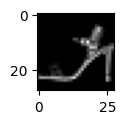

In [180]:
import matplotlib.pyplot as plt
# Obtener la fila específica que deseas imprimir (por ejemplo, fila 534)
fila_a_imprimir = X_test2.iloc[520]

# Obtener las características de la fila como un array numpy
data = fila_a_imprimir.values

# Reorganizar los datos en una matriz 28x28 para representar la imagen
image_data = data.reshape(28, 28)

# Configurar el tamaño de la figura
plt.figure(figsize=(1, 1))

# Mostrar la imagen
plt.imshow(image_data, cmap='gray')
valor_prediccion = predicciones_df2.iloc[520]['Predicciones_Texto']
print(valor_prediccion)

plt.show()

Finalmente una vez comprobado el funcionamiento anterior, se realiza una iteración para mostrar 20 imagenes junto a su respectiva predicción utilizando 20 valores aleatorios dentro del rango de las predicciones.



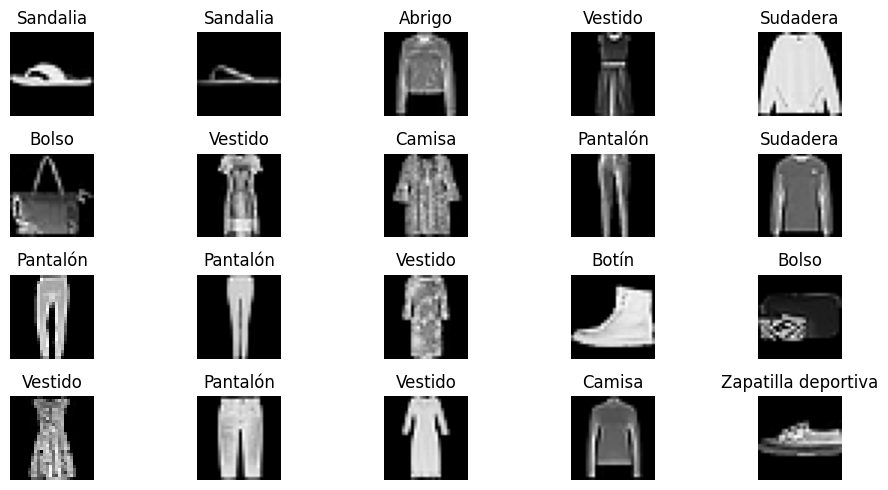

In [181]:

# Obtener 20 índices aleatorios dentro del rango de predicciones_df2
indices_aleatorios = random.sample(range(len(predicciones_df2)), 20)

# Configurar el tamaño de la figura para mostrar varias imágenes
plt.figure(figsize=(10, 5))

# Iterar sobre los índices aleatorios
for i, idx in enumerate(indices_aleatorios):
    # Obtener la fila específica que deseas imprimir
    fila_a_imprimir = X_test2.iloc[idx]
    # Obtener las características de la fila como un array numpy
    data = fila_a_imprimir.values
    # Reorganizar los datos en una matriz 28x28 para representar la imagen
    image_data = data.reshape(28, 28)

    # Mostrar la imagen en una subfigura
    plt.subplot(4, 5, i + 1)
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Deshabilitar los ejes
    valor_prediccion = predicciones_df2.iloc[idx]['Predicciones_Texto']
    plt.title(valor_prediccion)  # Añadir el nombre como título

plt.tight_layout()  # Ajustar el diseño de las subfiguras
plt.show()